In [253]:
# Import dependancies
import tweepy
import re
import requests
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import pickle
import time
import itertools
import networkx as nx
import matplotlib.pyplot as plt
import nltk
import ast
import community
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

The user_id column has to be read as a str:

In [254]:
# Load data
usernames_uk = pd.read_csv("data_w_usernames_UK.csv",index_col=0, dtype={'user_id':str})

C:\Users\difra\AppData\Local\Temp\ipykernel_18484\3311480369.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  usernames_uk = pd.read_csv("data_w_usernames_UK.csv",index_col=0, dtype={'user_id':str})


In [255]:
usernames_uk = usernames_uk.reset_index(drop = True)

In [256]:
mentions = pd.read_csv("mentions.csv", index_col = 0)
mentions = mentions.reset_index(drop=True)

Merging the dataframe that contains only the twitter with at least one mention with the dataframe that contained the scraped usernames

In [257]:
mentions['username'] = pd.merge(mentions, usernames_uk, on = "tweet_ID").iloc[:, -1] 

In [258]:
data_df = mentions

In [259]:
data_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1234294853330182144,20973388,covid,2020-03-02 01:49:59,0.406,0.613,0.458,0.271,0.460,-1.0,F,"The UK government is considering all options, ...",27.0,['darrenadam'],PatrickDoyle83
1,1234305116506861568,442831126,covid,2020-03-02 02:30:46,0.665,0.326,0.373,0.443,0.325,1.0,H,@Grummz An article for you after yesterday's m...,18.0,['Grummz'],BatemanStuart1
2,1234310189404348417,1157949934949347328,wuhan,2020-03-02 02:50:56,0.371,0.525,0.426,0.234,0.455,-1.0,F,@fascinatorfun So question is why the mortalit...,14.0,['fascinatorfun'],MUVAHOOD
3,1234318241431990272,16027848,covid,2020-03-02 03:22:55,0.329,0.587,0.570,0.138,0.474,-1.0,F,Video: #ToxicTories try to hide damage to NHS ...,27.0,['skwawkbox'],deadendfriends8
4,1234321940401270785,282914879,covid,2020-03-02 03:37:37,0.514,0.364,0.370,0.361,0.360,0.0,NaN,"@dray24574721 @BNODesk This, from S Korea afte...",15.0,"['dray24574721', 'BNODesk']",hoglet3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271091,1285835534766673923,916192094330507264,covid,2020-07-22 07:14:15,0.629,0.306,0.315,0.454,0.285,1.0,H,#Reboot weekends have started up again. #covi...,24.0,['actressann'],NaN
271092,1285835650059636736,3057049653,covid,2020-07-22 07:14:43,0.440,0.399,0.464,0.245,0.436,-1.0,A,@Gnomeponders My daughter and partner are both...,20.0,['Gnomeponders'],NaN
271093,1285835723740856321,216650916,covid,2020-07-22 07:15:00,0.598,0.336,0.330,0.406,0.318,1.0,H,Join on September 1st @ 5pm for a HealthChat w...,41.0,['RoyLilley'],NaN
271094,1285835987424337921,75508547,corona,2020-07-22 07:16:03,0.250,0.507,0.608,0.141,0.508,-2.0,A,@sidudeja But why would you want anyone dead? ...,24.0,['sidudeja'],NaN


Removing the rows for which it was not possible to retrieve the usernames:

In [260]:
data_df = data_df.dropna(subset='username').reset_index(drop=True)

In [261]:
data_df

,tweet_ID,user_id,keywords,tweet_timestamp,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment,emotion,tweet,len_content,mentions,username
0,1234294853330182144,20973388,covid,2020-03-02 01:49:59,0.406,0.613,0.458,0.271,0.460,-1.0,F,"The UK government is considering all options, ...",27.0,['darrenadam'],PatrickDoyle83
1,1234305116506861568,442831126,covid,2020-03-02 02:30:46,0.665,0.326,0.373,0.443,0.325,1.0,H,@Grummz An article for you after yesterday's m...,18.0,['Grummz'],BatemanStuart1
2,1234310189404348417,1157949934949347328,wuhan,2020-03-02 02:50:56,0.371,0.525,0.426,0.234,0.455,-1.0,F,@fascinatorfun So question is why the mortalit...,14.0,['fascinatorfun'],MUVAHOOD
3,1234318241431990272,16027848,covid,2020-03-02 03:22:55,0.329,0.587,0.570,0.138,0.474,-1.0,F,Video: #ToxicTories try to hide damage to NHS ...,27.0,['skwawkbox'],deadendfriends8
4,1234321940401270785,282914879,covid,2020-03-02 03:37:37,0.514,0.364,0.370,0.361,0.360,0.0,NaN,"@dray24574721 @BNODesk This, from S Korea afte...",15.0,"['dray24574721', 'BNODesk']",hoglet3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269755,1285590859094863873,104942955,covid,2020-07-21 15:02:00,0.634,0.270,0.329,0.419,0.296,1.0,H,🌟 Free HR Advice 🌟\n\nInspiring People HR @Ins...,35.0,['InspiringPplHR'],opus_llp
269756,1285590913683722242,556875827,covid,2020-07-21 15:02:13,0.536,0.462,0.382,0.381,0.389,1.0,H,Excellent blog by @M_Winthrop - on the impacts...,32.0,['M_Winthrop'],bradleyyyshea
269757,1285591051756023809,102957958,covid,2020-07-21 15:02:46,0.578,0.405,0.402,0.348,0.389,1.0,H,#Wellbeing | Protecting #BAME employees from #...,36.0,['Generali_UK'],JarobeHHF
269758,1285591471194857474,1080551330849136641,covid,2020-07-21 15:04:26,0.399,0.414,0.458,0.275,0.485,-1.0,S,"@itslifeaslolly All but 3, due to complication...",43.0,['itslifeaslolly'],YLALawyers


To read each list in the column 'mentions' as a list and not as a str:

In [262]:
data_df['mentions'] = data_df['mentions'].apply(ast.literal_eval)

# Network

In [179]:
dict_edges = dict(zip(data_df['username'], data_df['mentions']))

In [13]:
g = nx.DiGraph(dict_edges)

In [14]:
len(g.edges)

256041

In [15]:
len(g.nodes)

255126

In [16]:
in_degree_tuples = g.in_degree(g.nodes())
in_degree = [x[1] for x in in_degree_tuples] 

In [17]:
out_degree_tuples = g.out_degree(g.nodes())
out_degree = [x[1] for x in out_degree_tuples] 

Comparison of in-degree and out-degree distributions. The in-degree distribution has been zoomed to make it clear that for most of the users the in-degree is similar to the out degree except for some outliers that have very large in-degree because probably they are famous accounts such as news account or popular people (politicians or influencers) or famous organizations.

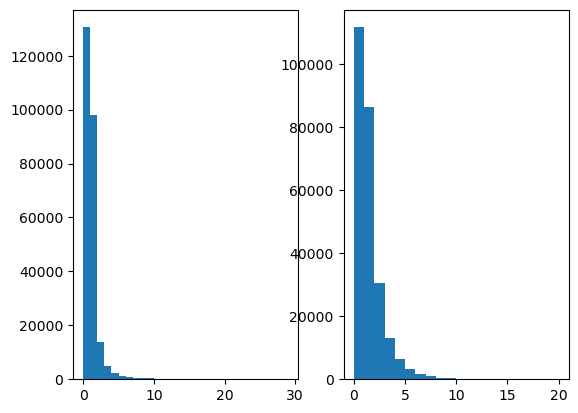

In [18]:
fig, axes = plt.subplots(1, 2)

axes[0].hist(in_degree, bins = np.arange(np.min(in_degree), 30))
axes[1].hist(out_degree, bins = np.arange(np.min(out_degree), np.max(out_degree)+2))

plt.show()

In-degree distribution plotted using a log scale for the y axis:

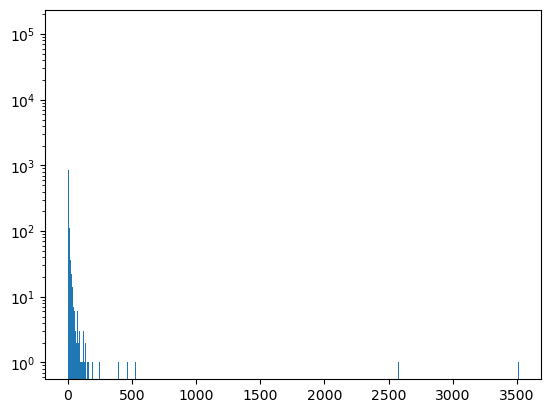

In [19]:
plt.hist(in_degree, bins = np.arange(np.min(in_degree), np.max(in_degree)+2))
plt.yscale('log')
plt.show()

In [20]:
dict_in_degree = dict(g.in_degree(g.nodes))
print("Top most in-degree connected users: ,", sorted(dict_in_degree, key=dict_in_degree.get, reverse=True)[:20])
dict_out_degree = dict(g.out_degree(g.nodes))
print("Top most out-degree connected users: ,", sorted(dict_out_degree, key=dict_out_degree.get, reverse=True)[:10])

Top most in-degree connected users: , ['BorisJohnson', 'piersmorgan', 'UKChange', 'MattHancock', 'realDonaldTrump', 'YouTube', 'BBCNews', 'SkyNews', 'NicolaSturgeon', 'ProfKarolSikora', 'WHO', '10DowningStreet', 'PHE_uk', 'GMB', 'Keir_Starmer', 'RishiSunak', 'afneil', 'MailOnline', 'guardian', 'LBC']
Top most out-degree connected users: , ['Richwfc2', 'rrigby83', 'compersnews12', 'BB1887', '___Mollyyy___', 'Rachel_Slawson', 'neil_ackland', 'naomi_jones', 'KieranM82920843', 'ConnorTeri1']


# Tweets analysis

Remove links from tweet:

In [400]:
def find_https(tweet):
    tweet =re.sub('\.*amp\.*', '', tweet.lower())
    return re.sub("(http|https)://[\w\-]+(\.[\w\-]+)+\S*",'', tweet)
    

In [401]:
data_df['tweet'] = data_df['tweet'].apply(find_https)

Tokenize the tweets:

In [460]:
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+') 

def tokenize_tweet(tweet):
    word_tokens = tokenizer.tokenize(tweet)
    filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words and not w.lower() in ['corona', 'wuhan', 'ncov', 'covid', 'covid_19', 'covid19', 'coronavirus']]
    return filtered_sentence


In [461]:
data_df['tokens'] = data_df['tweet'].apply(tokenize_tweet)


In [426]:
def remove_mentions(x, y):
    for el in y:
        try:
            x.remove(el.lower())
        except:
            pass


In [269]:
data_df.apply(lambda x: remove_mentions(x['tokens'], x['mentions']), axis=1)

0         None
1         None
2         None
3         None
4         None
          ... 
269755    None
269756    None
269757    None
269758    None
269759    None
Length: 269760, dtype: object

In [194]:
#data_df['tweet_timestamp'] = pd.to_datetime(data_df['tweet_timestamp'], format='%Y-%m-%d %H:%M:%S')

In [404]:
#%%timeit
#def merge_dicts(x):
   #return {k: v for d in x.dropna() for k, v in d.items()}

#ord_count_weekly = data_df.groupby(pd.Grouper(key='tweet_timestamp', axis=0, freq='7D', sort=True))['word_count'].sum()

# Identify communities

In order to identify communities within the UK network we have to first transform it to an undirected graph:

In [271]:
u_g = g.to_undirected()

We use the unsupervised Louvain Algorithm for detecting communities:

In [272]:
partition = community.best_partition(u_g)

In [273]:
communities = np.unique(list(partition.values()))

The number of communities found is very large, however this was expected given the network also have numerous connections:

In [274]:
communities 

array([    0,     1,     2, ..., 37468, 37469, 37470])

In [275]:
d_input = dict(partition.items())
res = {}
for i, v in d_input.items():
    res[v] = [i] if v not in res.keys() else res[v] + [i]

Extracting the 10 largest communities only:

In [463]:
count = 0
largest_communities = sorted(res.items(), key=lambda v: len(v[1]), reverse=True)[:10]
texts = []

for i,t in enumerate(largest_communities):
    texts.append(np.concatenate(data_df.loc[data_df['username'].isin(t[1])]['tokens'].values))
    print(f"Community n. {i+1}. Size: {len(t[1])}")
    count += len(t[1])
    
print(f"\nAround {int(np.round(count/len(u_g.nodes), 2)*100)}% of network nodes is represented in these partitions.")

Community n. 1. Size: 10655
Community n. 2. Size: 6899
Community n. 3. Size: 6115
Community n. 4. Size: 5101
Community n. 5. Size: 5065
Community n. 6. Size: 4680
Community n. 7. Size: 3320
Community n. 8. Size: 2655
Community n. 9. Size: 2604
Community n. 10. Size: 2584

Around 19% of network nodes is represented in these partitions.


In [464]:
# to calculate the tf:
tf_texts = pd.Series(texts).apply(nltk.FreqDist)

In [465]:
doc_freq = nltk.FreqDist(np.concatenate(pd.Series(texts).apply(lambda x: list(set(x))).values))

In [466]:
idf_values = np.log10((1+21/(1+np.array(list(doc_freq.values()))))) + 1

In [467]:
idf = dict(zip(doc_freq.keys(), idf_values))

In [468]:
def calculate_tf_idf(tf, idf):
    return dict(zip(list(tf.keys()), np.array(list(tf.values()))*np.array([idf.get(w) for w in list(tf.keys())])))

In [469]:
tf_idf_series = pd.Series(tf_texts).apply(lambda x: calculate_tf_idf(x, idf))

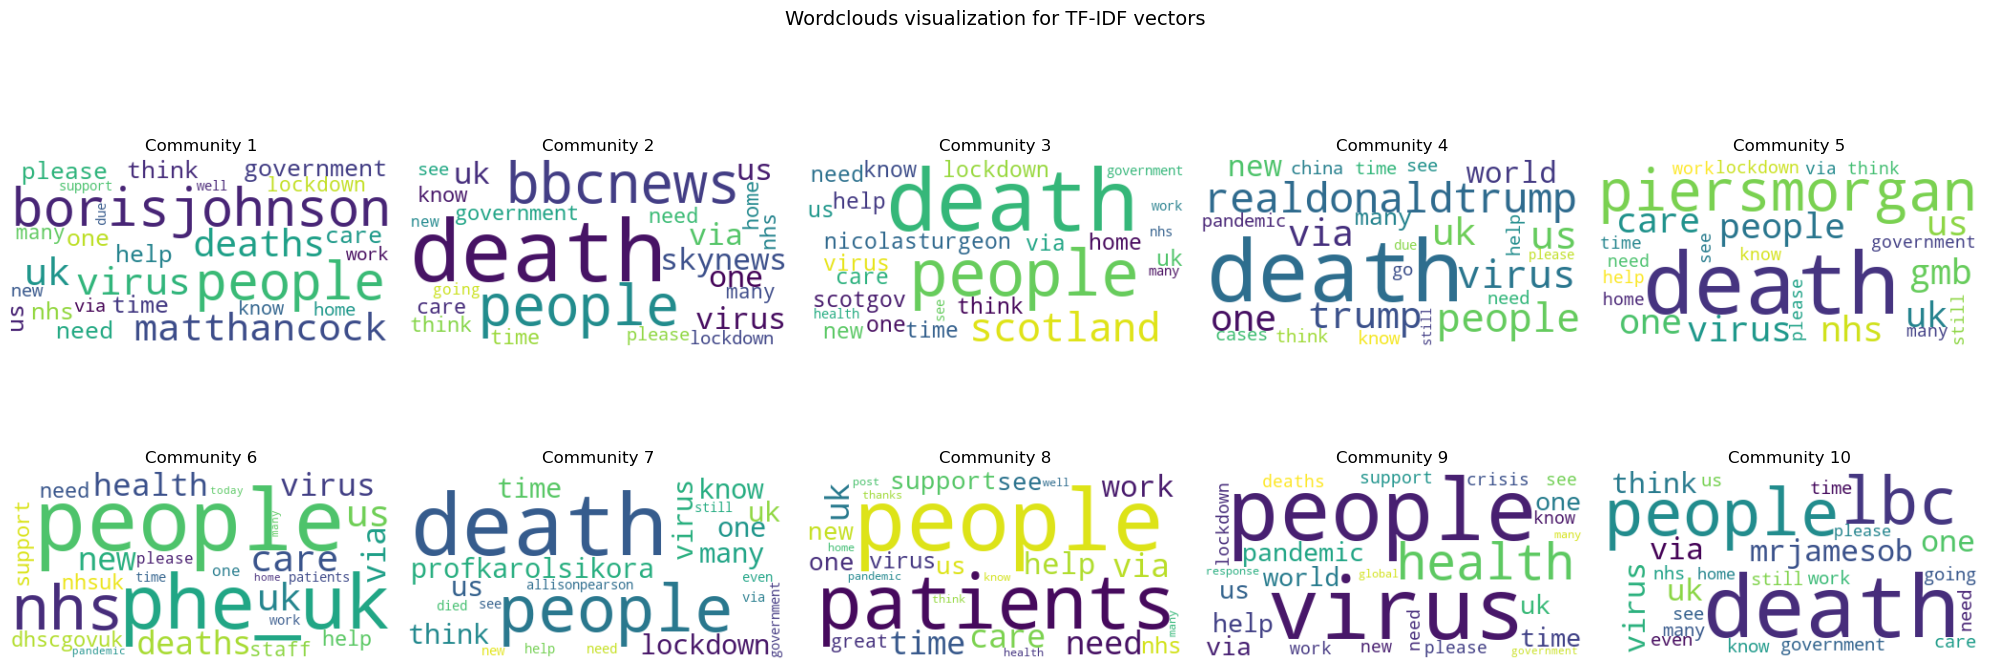

In [470]:
fig, ax = plt.subplots(2, 5, figsize= (20, 8))

c = 0
for i in range(2):
    for j in range(5):
        list_w = sorted(tf_idf_series[c], key=tf_idf_series[c].get, reverse=True)[:30]
        wordcloud = WordCloud(max_font_size=90, max_words=30, background_color="white").generate(" ".join(list_w))
        ax[i][j].imshow(wordcloud, interpolation="bilinear")
        ax[i][j].set_axis_off()
        ax[i][j].set_title(f"Community {c+1}")
        c += 1
fig.suptitle("Wordclouds visualization for TF-IDF vectors", fontsize = 14)
fig.tight_layout()
plt.show()